# Pix2Pix GAN (style-based Pix2Pix GAN to be implemented)

**Materials:**

- [Machine Learning Mastery](https://machinelearningmastery.com/how-to-implement-pix2pix-gan-models-from-scratch-with-keras/)

In [6]:
# fix imports
from fix_imports import fix_relative_imports
fix_relative_imports()

In [1]:
from keras.utils import plot_model

### Discriminator: PatchGAN 

Visualize and use model

/Users/guilhermeleonardonunes/temp/computer-vision/implementations/.venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 concatenate_8 (Concatenate  (None, 256, 256, 6)          0         ['input_4[0][0]',             
 )                                                                   'input_5[0][0]']             
                                                                                                  
 conv2d_14 (Conv2D)          (None, 128, 128, 64)         6208      ['concatenate_8[0][0]'] 

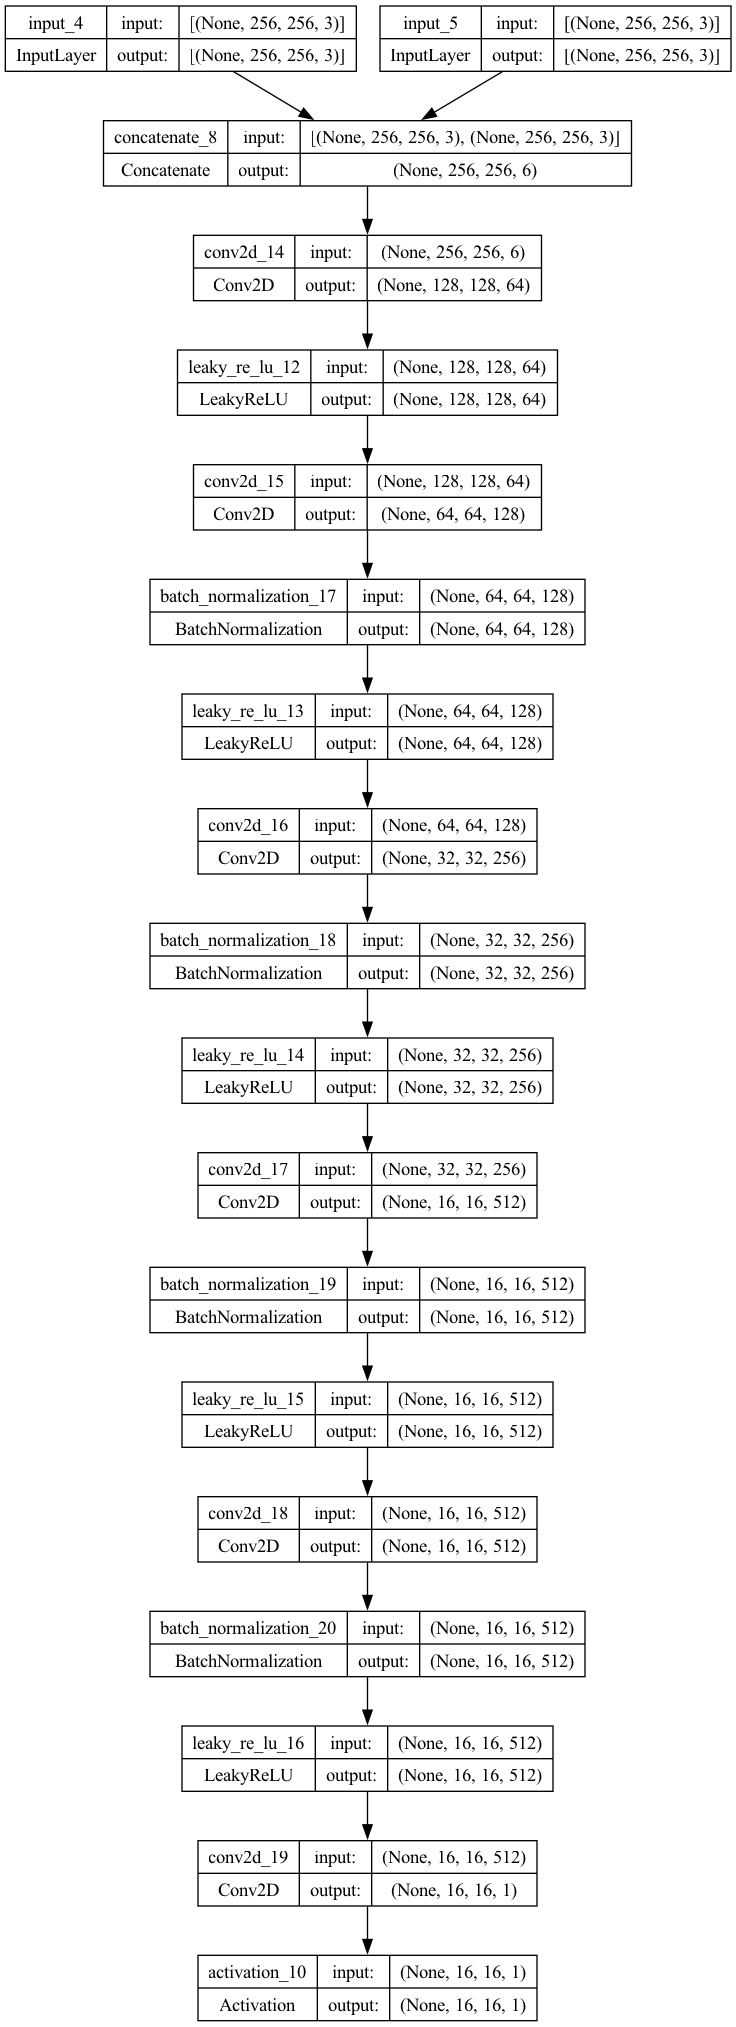

In [8]:
from pix2pix_gan.discriminator import create_discriminator

image_shape = (256,256,3)
discriminator_model = create_discriminator(image_shape)
discriminator_model.summary()
plot_model(discriminator_model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)


### Generator: U-Net

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 128, 128, 64)         3136      ['input_6[0][0]']             
                                                                                                  
 leaky_re_lu_17 (LeakyReLU)  (None, 128, 128, 64)         0         ['conv2d_20[0][0]']           
                                                                                                  
 conv2d_21 (Conv2D)          (None, 64, 64, 128)          131200    ['leaky_re_lu_17[0][0]']      
                                                                                            

/Users/guilhermeleonardonunes/temp/computer-vision/implementations/.venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


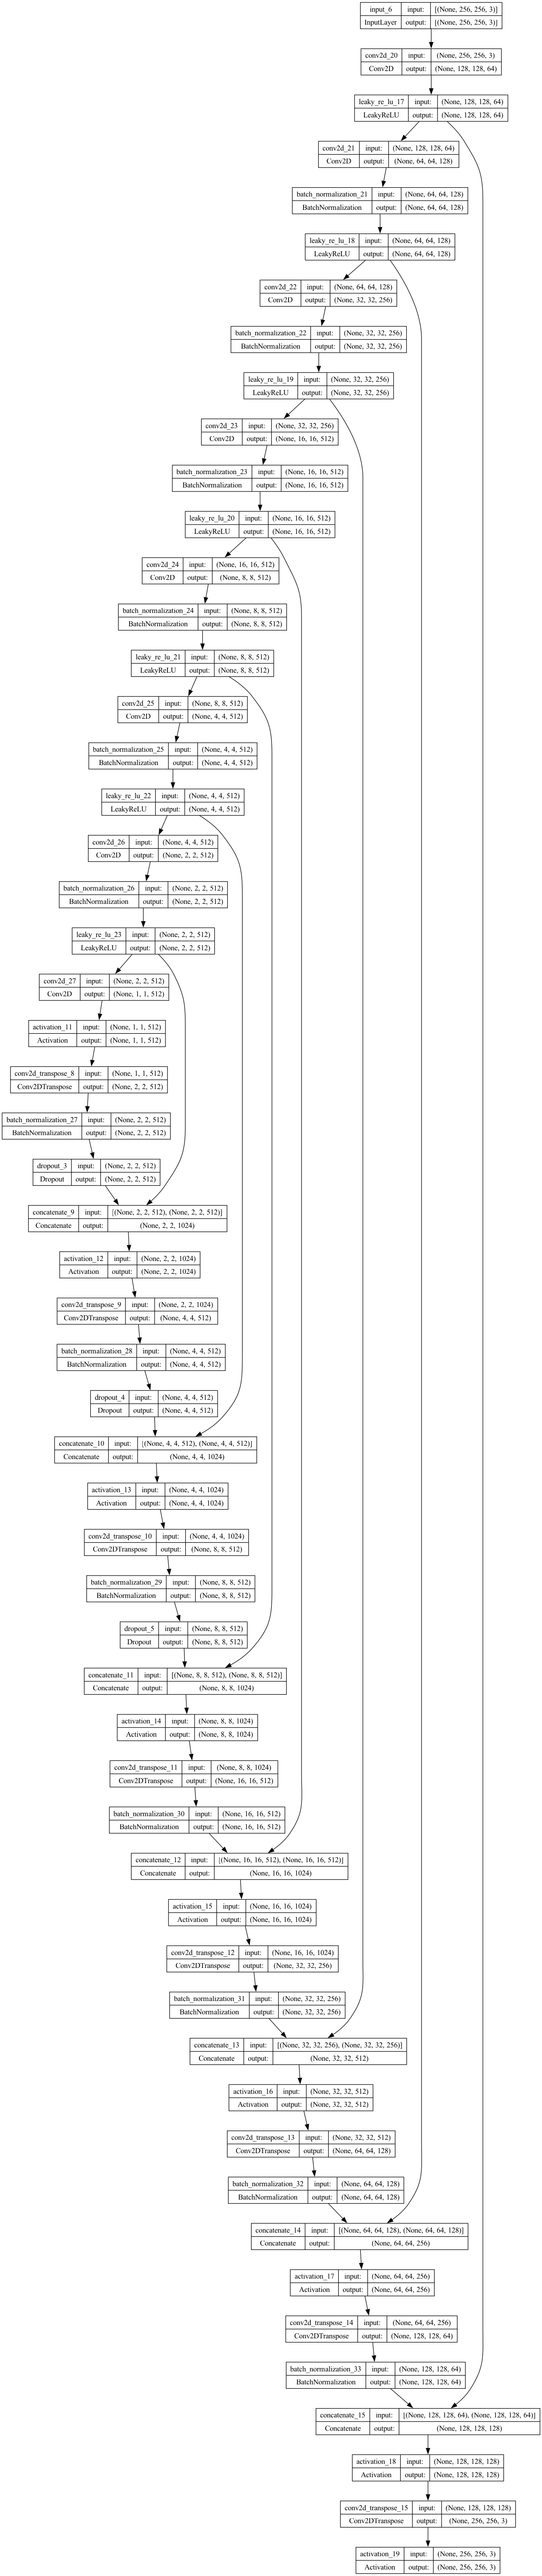

In [9]:
from pix2pix_gan.generator import create_generator

image_shape = (256,256,3)
generator_model = create_generator(image_shape)
generator_model.summary()
plot_model(generator_model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)

## 3. GAN

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 model_3 (Functional)        (None, 256, 256, 3)          5442931   ['input_7[0][0]']             
                                                          5                                       
                                                                                                  
 model_2 (Functional)        (None, 16, 16, 1)            6968257   ['input_7[0][0]',             
                                                                     'model_3[0][0]']             
                                                                                            

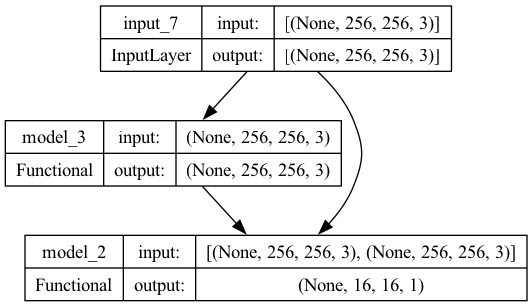

In [10]:
from pix2pix_gan.gan import create_gan

image_shape = (256,256,3)
gan_model = create_gan(
    generator_model=generator_model,
    discriminator_model=discriminator_model,
    image_shape=image_shape,
)

gan_model.summary()
plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

## 4. Load Data

In [12]:
import os
import pathlib
import time
import datetime
import tensorflow as tf

from matplotlib import pyplot as plt

dataset_name = "facades"
DATA_PATH = "../data"
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

30168306/30168306 [==============================] - 64s 2us/step


In [14]:
list(PATH.parent.iterdir())
sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)


(256, 512, 3)


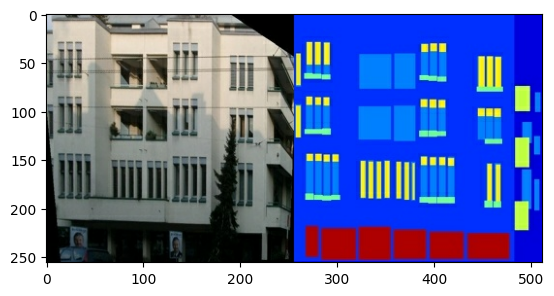

In [15]:
plt.figure()
plt.imshow(sample_image)


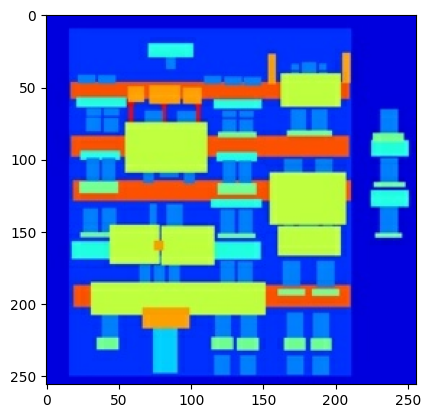

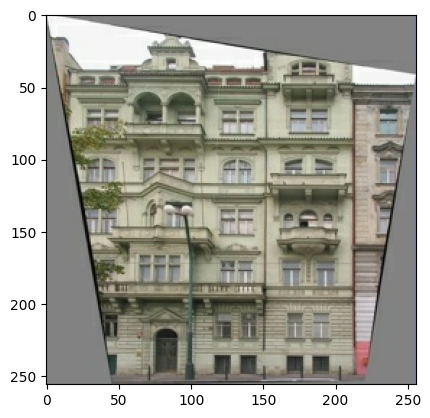

In [30]:
from preprocess.facade_preprocess import load_image

inp, re = load_image(str(PATH / 'train/100.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [35]:
from preprocess.facade_preprocess import random_jitter_preprocess

plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter_preprocess(inp, re)
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis('off')

plt.show()

ImportError: cannot import name 'random_jitter_preprocess' from 'preprocess.facade_preprocess' (/Users/guilhermeleonardonunes/temp/computer-vision/implementations/pix2pix_lung_cancer/preprocess/facade_preprocess.py)

## 5. Define Training Function

In [ ]:
def train(
    discriminator_model,
    generator_model,
    gan_model,
    dataset,
    n_epochs: int=100,
    n_batch: int=1,
    n_patch: int=16,
):
    # unpack trainset
    trainA, trainB = dataset
    # calculate number of batches per epoch
    batch_per_epoch = int(len(trainA) / n_batch)
    # calculate number of training iterations
    n_steps = batch_per_epoch * n_epochs
    for i in range(n_steps):
        # select a batch of real samples
        X_realA, X_realB = get_real_samples(trainA, trainB, n_batch, n_patch)
        